# <span style="color:#820747">3. Modeling (NLP + LogisticRegression to predict salary price).
                                                                                             by Pavel Tarasenko

# <span style="color:#6e750e">Navigator:

<b>[1. WebScraping](./1_WebScraping-and-Cleaning-Data.ipynb)

<b>[2. My EDA](./2_EDA.ipynb)

<b>[4. Factors that distinguish job category](./4_Factors that distinguish job category.ipynb)

<b>[5. TECHNICAL REPORT](./Technical_report.txt)

<b>[6. NON TECHNICAL REPORT](./Non_technical_report.txt)

<span style="color:red">
--- comment ---

<span style="color:#1d5dec"> In this part I will do modeling to predict the price. Price will be predicted as 0 and 1, where 0 salary below median ($110000) and 1 salary above median. To do this I will use Natural Language Processing (NLP) to find predictors from 'title', 'summary', 'job_bio', 'company' and 'cities'. After I will fit it into LogisticRegression model, and train my model on train data, then I will test it on test data. Later I will take my data without salary and predict salary prices for the rest of jobs. Next step will be concatenation two parts into one. 

In [91]:
# Import all necessary libraries.
# -----------------------------------------------------
import matplotlib.pyplot as plt
import pandas as pd
import bs4
import re
import time
import numpy as np
import sklearn
from time import sleep
import requests
import seaborn as sns

from statistics import median
import matplotlib as mpl
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from selenium import webdriver
from bs4 import BeautifulSoup
import urllib.request, urllib.parse, urllib.error

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
# Load my working csv file into df variable.
# -----------------------------------------------------
df = pd.read_csv('4_salary_no_outliers.csv')

In [5]:
# Split the data and make it binary: 1 = salary > median and 0 = salary < median. Our Median == $110000
# -----------------------------------------------------
df["Salary_grater_median"] = np.nan
df.ix[df["salary"] > df["salary"].median(), "Salary_grater_median"] = 1
df.ix[df["salary"] <= df["salary"].median(), "Salary_grater_median"] = 0

In [8]:
# Check if I got what I want. 
# -----------------------------------------------------
df.head(3)

,location,title,company,salary,Salary_type,summary,job_bio,level,Salary_grater_median
0,sydney,data science research engineer,macquarie university,106382.0,year,we are seeking a data science research enginee...,macquarie is the university of pioneering mind...,middle,0.0
1,sydney,senior software engineer machine learning,rokt,137500.0,year,a strong statistical background and or experie...,exceptional opportunity to join one of the fas...,senior,1.0
2,sydney,event research analyst,destination nsw corporate services,93704.5,year,outline your experience in carrying out market...,event research analyst 0000650n ongoing fu...,middle,0.0


<span style="color:red">
--- comment ---

<span style="color:#1d5dec"> My DataFrame (df) doesnt include any nulls values, I will use it to train my model. 

In [14]:
# Split my data into target and features. Print out my target. 
# -----------------------------------------------------
features = df.iloc[:,0:len(df_with_salary.columns)-1]
target = pd.DataFrame(df['Salary_grater_median'])
target.head(3)

,Salary_grater_median
0,0.0
1,1.0
2,0.0


In [15]:
# Print out my features which I will use to aplly NLP on it, to find my predictors. 
# -----------------------------------------------------
features.head(1)

,location,title,company,salary,Salary_type,summary,job_bio,level
0,sydney,data science research engineer,macquarie university,106382.0,year,we are seeking a data science research enginee...,macquarie is the university of pioneering mind...,middle


<span style="color:red">
--- comment ---

<span style="color:#1d5dec"> From here I will start using NLP to get my predictors for future use in my LogisticRegression to predict salary price. 

# <span style="color:#15b01a"> 1. Search for words in title

In [16]:
# Fit my count vectorizer to the title and make our title data into title_train. I remove some unneeded words with 
# 'stop_words='english'', I set 'ngram_range = (1, 3)' to go through all combination words max 3 words. 
# 'min_df I set 0.25% which will show me only word which appears more than 0.25% in a text. 
# -----------------------------------------------------
cvec = CountVectorizer(stop_words='english', ngram_range=(1, 3), min_df = .025)
cvec.fit(features['title'])
title_train = pd.DataFrame(cvec.transform(features['title']).todense(), columns=cvec.get_feature_names())
title_train.head(6)

,analyst,analytics,business,business analyst,commercial,commercial analyst,consultant,contract,data,data analyst,...,manager,project,research,scientist,senior,senior business,senior business analyst,sydney,systems,technical
0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [17]:
# Put our target next to n-grams table. It will be useful in my next loop to count word in two different categories.
# -----------------------------------------------------
words_to_target = pd.concat([title_train, target], axis=1)

In [25]:
# Use for loop to count most common words in category grater than median and lower than median
# -----------------------------------------------------
for i in range(2):  # set range to go through 0 and 1
    word_count = words_to_target[words_to_target["Salary_grater_median"] == i].sum(axis=0)
    print("Most common words for: ", i)
    print('-------------------------')
    w = word_count.sort_values(ascending = False).head(10)
    print(w)
    print('')

Most common words for:  0
-------------------------
analyst             293.0
data                 96.0
business             92.0
business analyst     72.0
data analyst         54.0
senior               39.0
financial            21.0
finance              20.0
commercial           18.0
manager              17.0
dtype: float64

Most common words for:  1
-------------------------
Salary_grater_median    379.0
analyst                 229.0
business                131.0
senior                  106.0
business analyst        106.0
data                     95.0
senior business          27.0
manager                  27.0
engineer                 23.0
developer                23.0
dtype: float64



In [26]:
# I create 2 separate lists below/above median with top appearing words. Now it can be combined and compared to
# create ratios of appearances in above vs below median salaries.
# -----------------------------------------------------
word_count_below = words_to_target[words_to_target["Salary_grater_median"] == 0].sum(axis = 0)
word_count_above = words_to_target[words_to_target["Salary_grater_median"] == 1].sum(axis = 0)

# Creating as DataFrame, using method ".T" to transpose columns with index.
# -----------------------------------------------------
word_count_compare = pd.DataFrame([word_count_below, word_count_above]).T

# Create a new column 'above_below_ratio' to find frequency of words associated with my two groups 0/1 median jobs.
# -----------------------------------------------------
word_count_compare["above_below_ratio"] = word_count_compare[1] / word_count_compare[0]
word_count_compare.above_below_ratio.sort_values(ascending=False)

Salary_grater_median            inf
senior business            4.500000
senior business analyst    3.500000
senior                     2.717949
lead                       2.000000
contract                   2.000000
engineer                   1.769231
developer                  1.769231
systems                    1.625000
manager                    1.588235
business analyst           1.472222
analytics                  1.454545
business                   1.423913
data scientist             1.142857
technical                  1.076923
scientist                  1.000000
data                       0.989583
project                    0.909091
finance                    0.850000
consultant                 0.812500
analyst                    0.781570
sydney                     0.769231
financial                  0.666667
commercial analyst         0.571429
digital                    0.500000
commercial                 0.500000
research                   0.312500
data analyst               0

In [ ]:
# Later I will use top  5 and low  5 words to create my features.

<span style="color:red">
--- comment ---

<span style="color:#1d5dec"> Now I do same thing for the rest of my columns. 

# <span style="color:#15b01a"> 2. Search for words in company

In [43]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1, 3), min_df = .02)
cvec.fit(features['company'])
company_train = pd.DataFrame(cvec.transform(features['company']).todense(), columns=cvec.get_feature_names())
company_train.head(6)

,australia,carter,consulting,group,half,half australia,hays,hudson,michael,michael page,...,recruitment,resources,robert,robert half,robert half australia,services,sharp,sharp carter,solutions,university
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
words_to_target_company = pd.concat([company_train, target], axis=1)

In [45]:
for i in range(2):  # set range to go through 0 and 1
    word_count = words_to_target_company[words_to_target_company["Salary_grater_median"] == i].sum(axis=0)
    print("Most common words for: ", i)
    print('-------------------------')
    w = word_count.sort_values(ascending = False).head(10)
    print(w)
    print('')

Most common words for:  0
-------------------------
recruitment     51.0
page            47.0
michael         44.0
michael page    44.0
australia       36.0
hays            30.0
group           27.0
pty             25.0
university      25.0
robert half     20.0
dtype: float64

Most common words for:  1
-------------------------
Salary_grater_median    379.0
recruitment              48.0
group                    34.0
hudson                   29.0
australia                24.0
michael page             22.0
michael                  22.0
page                     22.0
pty                      21.0
hays                     20.0
dtype: float64



In [46]:
word_count_below = words_to_target_company[words_to_target_company["Salary_grater_median"] == 0].sum(axis = 0)
word_count_above = words_to_target_company[words_to_target_company["Salary_grater_median"] == 1].sum(axis = 0)

word_count_compare = pd.DataFrame([word_count_below, word_count_above]).T

word_count_compare["above_below_ratio"] = word_count_compare[1]/word_count_compare[0]
word_count_compare.above_below_ratio.sort_values(ascending=False)

Salary_grater_median          inf
hudson                   4.142857
carter                   2.800000
sharp carter             2.800000
sharp                    2.800000
consulting               2.250000
resources                1.571429
group                    1.259259
solutions                1.083333
recruitment              0.941176
robert half              0.900000
robert                   0.900000
half australia           0.900000
robert half australia    0.900000
half                     0.900000
pty                      0.840000
services                 0.727273
morgan                   0.700000
australia                0.666667
hays                     0.666667
michael                  0.500000
michael page             0.500000
page                     0.468085
university               0.400000
Name: above_below_ratio, dtype: float64

In [ ]:
# later I will use top = hudson & carter & sharp carter  low = university & page & michael page

# <span style="color:#15b01a"> 3. Search for words in summary

In [31]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1, 3), min_df = .025)
cvec.fit(features['summary'])
company_train = pd.DataFrame(cvec.transform(features['summary']).todense(), columns=cvec.get_feature_names())
company_train.head(6)

,ability,analyse,analysis,analyst,analyst join,analyst role,analysts,analytics,assist,based,...,support,systems,team,technical,technology,understanding,work,working,years,years experience
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
words_to_target_summary = pd.concat([company_train, target], axis=1)

In [33]:
for i in range(2):
    word_count = words_to_target_summary[words_to_target_summary["Salary_grater_median"] == i].sum(axis=0)
    print("Most common words for: ", i)
    print('-------------------------')
    w = word_count.sort_values(ascending = False).head(10)
    print(w)
    print('')

Most common words for:  0
-------------------------
data                384.0
business            317.0
analyst             203.0
experience           86.0
business analyst     72.0
analysis             71.0
team                 63.0
big                  61.0
role                 60.0
financial            51.0
dtype: float64

Most common words for:  1
-------------------------
data                    389.0
Salary_grater_median    379.0
business                328.0
analyst                 204.0
business analyst        114.0
experience              110.0
senior                   62.0
analysis                 61.0
big                      55.0
team                     54.0
dtype: float64



In [34]:
word_count_below = words_to_target_summary[words_to_target_summary["Salary_grater_median"] == 0].sum(axis = 0)
word_count_above = words_to_target_summary[words_to_target_summary["Salary_grater_median"] == 1].sum(axis = 0)

word_count_compare = pd.DataFrame([word_count_below, word_count_above]).T

word_count_compare["above_below_ratio"] = word_count_compare[1] / word_count_compare[0]
word_count_compare.above_below_ratio.sort_values(ascending=False)

Salary_grater_median         inf
senior business         4.500000
based                   3.428571
business analysts       2.625000
processes               2.125000
develop                 2.100000
senior                  1.878788
scientists              1.700000
currently               1.636364
projects                1.615385
business analyst        1.583333
process                 1.571429
requirements            1.571429
years experience        1.500000
highly                  1.416667
big data                1.416667
technical               1.411765
understanding           1.357143
management              1.280000
experience              1.279070
planning                1.272727
solutions               1.230769
project                 1.222222
seeking                 1.200000
complex                 1.181818
reporting               1.176471
experience business     1.153846
analysts                1.153846
responsible             1.150000
including               1.133333
          

In [ ]:
# Later I will use top  5 = senior business, business analysts, processes, develop, senior
# low 5 = sales, commercial, analyst role, growth, reports

# <span style="color:#15b01a"> 4. Search for words in job_bio

In [35]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1, 3), min_df = .035)
cvec.fit(features['job_bio'])
company_train = pd.DataFrame(cvec.transform(features['job_bio']).todense(), columns=cvec.get_feature_names())

In [36]:
words_to_target_jobbio = pd.concat([company_train, target], axis=1)

In [37]:
for i in range(2):
    word_count = words_to_target_jobbio[words_to_target_jobbio["Salary_grater_median"] == i].sum(axis=0)
    print("Most common words for: ", i)
    print('-------------------------')
    w = word_count.sort_values(ascending = False).head(10)
    print(w)
    print('')

Most common words for:  0
-------------------------
window          11914.0
false            5480.0
false window     5283.0
ago              2995.0
days             2493.0
days ago         2469.0
apply            2158.0
data             1906.0
business         1815.0
analyst          1785.0
dtype: float64

Most common words for:  1
-------------------------
window          10150.0
false            4671.0
false window     4504.0
ago              2580.0
business         2470.0
days             2118.0
days ago         2091.0
apply            1992.0
data             1920.0
analyst          1479.0
dtype: float64



In [38]:
word_count_below = words_to_target_jobbio[words_to_target_jobbio["Salary_grater_median"] == 0].sum(axis = 0)
word_count_above = words_to_target_jobbio[words_to_target_jobbio["Salary_grater_median"] == 1].sum(axis = 0)

word_count_compare = pd.DataFrame([word_count_below, word_count_above]).T

word_count_compare["above_below_ratio"] = word_count_compare[1] / word_count_compare[0]
word_count_compare.above_below_ratio.sort_values(ascending=False)

Salary_grater_median            inf
extension                  6.333333
reporting analyst          5.555556
business analysis          5.133333
workshops                  5.000000
business process           4.571429
architect                  4.473684
submit application         4.428571
apply job senior           4.225806
job senior                 4.225806
source hudson              4.142857
source hudson window       4.142857
jobs hudson                4.142857
hudson window              4.142857
senior business analyst    3.812500
senior business            3.695652
submit                     3.625000
advantageous               3.571429
analyst data               3.500000
nsw government days        3.222222
proven experience          3.181818
greythorn                  3.076923
governance                 3.071429
aws                        3.071429
ict                        3.000000
sydney nsw 20              3.000000
ago senior business        3.000000
business analysts          3

In [ ]:
# Top 5 = extension, reporting analyst, business analysis, business process, architect 
# low 5 = institute, strong analytical, administrator, degree qualified , account 

# <span style="color:#735c12">Prepearing features for modeling.

<span style="color:red">
--- comment ---

<span style="color:#1d5dec">Now I got all my words I can use to do predictors from them. I will do binary features now using all those words I got using NLP. Also I'm going to make cities in to binary and use them as a predictors too. As soon my DataFrame will be ready I will plot it on heatmap. 

In [39]:
# Creating dammy variables. For the good_job_title if any of this words, I'm passing to check if they contains in 
# text, then make value = 1, same for the value = 0 but now we are using word which is less times appearing 
# in bio related to high sallary.                  
# -----------------------------------------------------
df_with_salary["good_job_title"] = 0
df_with_salary.ix[(df_with_salary["title"].str.contains("senior business") | 
            df_with_salary["title"].str.contains("senior business analyst") | 
            df_with_salary["title"].str.contains("senior") |
            df_with_salary["title"].str.contains("lead") |
            df_with_salary["title"].str.contains("contract"), "good_job_title")] = 1

df_with_salary["bad_job_title"] = 0
df_with_salary.ix[(df_with_salary["title"].str.contains("digital") | 
            df_with_salary["title"].str.contains("commercial") | 
            df_with_salary["title"].str.contains("research") |
            df_with_salary["title"].str.contains("data analyst") |
            df_with_salary["title"].str.contains("management"), "bad_job_title")] = 1

<span style="color:red">
--- comment ---

<span style="color:#1d5dec">Now I do the same to every column I got words from. 

In [47]:
# Company
# -----------------------------------------------------
df_with_salary["good_company"] = 0
df_with_salary.ix[(df_with_salary["company"].str.contains("hudson") |
                   df_with_salary["company"].str.contains("carter") |
                   df_with_salary["company"].str.contains("sharp carter"), "good_company")] = 1

df_with_salary["bad_company"] = 0
df_with_salary.ix[(df_with_salary["company"].str.contains("university") |
                   df_with_salary["company"].str.contains("page") |
                   df_with_salary["company"].str.contains("michael page"), "bad_company")] = 1

In [49]:
# Summary
# -----------------------------------------------------
df_with_salary["good_summary"] = 0
df_with_salary.ix[(df_with_salary["summary"].str.contains("senior business") |
                   df_with_salary["summary"].str.contains("business analysts") |
                   df_with_salary["summary"].str.contains("processes") |
                   df_with_salary["summary"].str.contains("develop") |
                   df_with_salary["summary"].str.contains("senior"), "good_summary")] = 1

df_with_salary["bad_summary"] = 0
df_with_salary.ix[(df_with_salary["summary"].str.contains("sales") |
                   df_with_salary["summary"].str.contains("commercial") |
                   df_with_salary["summary"].str.contains("analyst role") |
                   df_with_salary["summary"].str.contains("growth") |
                   df_with_salary["summary"].str.contains("reports"), "bad_summary")] = 1

In [51]:
# job_bio
# -----------------------------------------------------
df_with_salary["good_bio"] = 0
df_with_salary.ix[(df_with_salary["job_bio"].str.contains("extension") |
                   df_with_salary["job_bio"].str.contains("reporting analyst") |
                   df_with_salary["job_bio"].str.contains("business analysis") |
                   df_with_salary["job_bio"].str.contains("business process") |
                   df_with_salary["job_bio"].str.contains("architect"), "good_bio")] = 1

df_with_salary["bad_bio"] = 0
df_with_salary.ix[(df_with_salary["job_bio"].str.contains("institute") |
                   df_with_salary["job_bio"].str.contains("strong analytical") |
                   df_with_salary["job_bio"].str.contains("administrator") |
                   df_with_salary["job_bio"].str.contains("degree qualified") |
                   df_with_salary["job_bio"].str.contains("account"), "bad_bio")] = 1

In [53]:
# Make cities as dummy fitures
# -----------------------------------------------------
cities = pd.get_dummies(df_with_salary.location)
df_with_salary = pd.concat([df_with_salary, cities], axis=1)

In [54]:
# Check shape of my DataFrame with dummy variables and regular columns, at this stage I got 22 columns.
# -----------------------------------------------------
df_with_salary.shape

(825, 22)

In [56]:
df_with_salary.head(1)

,location,title,company,salary,Salary_type,summary,job_bio,level,Salary_grater_median,good_job_title,...,bad_company,good_summary,bad_summary,good_bio,bad_bio,adelaide,brisbane,melbourne,perth,sydney
0,sydney,data science research engineer,macquarie university,106382.0,year,we are seeking a data science research enginee...,macquarie is the university of pioneering mind...,middle,0.0,0,...,1,0,0,1,1,0,0,0,0,1


In [57]:
#Drop unneeded columns and keep only features with dummy variables, assign it in to new df_binary.
# -----------------------------------------------------
df_binary = df_with_salary.drop(['location', 'title', 'company', 'salary', 'Salary_type', 'summary', 'job_bio', 'level'], axis=1)

In [58]:
# Now I got my binary features. 
# -----------------------------------------------------
df_binary.head(3)

,Salary_grater_median,good_job_title,bad_job_title,good_company,bad_company,good_summary,bad_summary,good_bio,bad_bio,adelaide,brisbane,melbourne,perth,sydney
0,0.0,0,1,0,1,0,0,1,1,0,0,0,0,1
1,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,0.0,0,1,0,0,0,0,0,0,0,0,0,0,1


<span style="color:red">
--- comment ---

<span style="color:#1d5dec">I will plot my features on heatmap, to see if there is any collinearity between features. From the graph I can see that only Melbourne vs Sydney has correlation 0.72 which is high but my threshold for collinearity is 0.75, In this case I keep everything without changes.

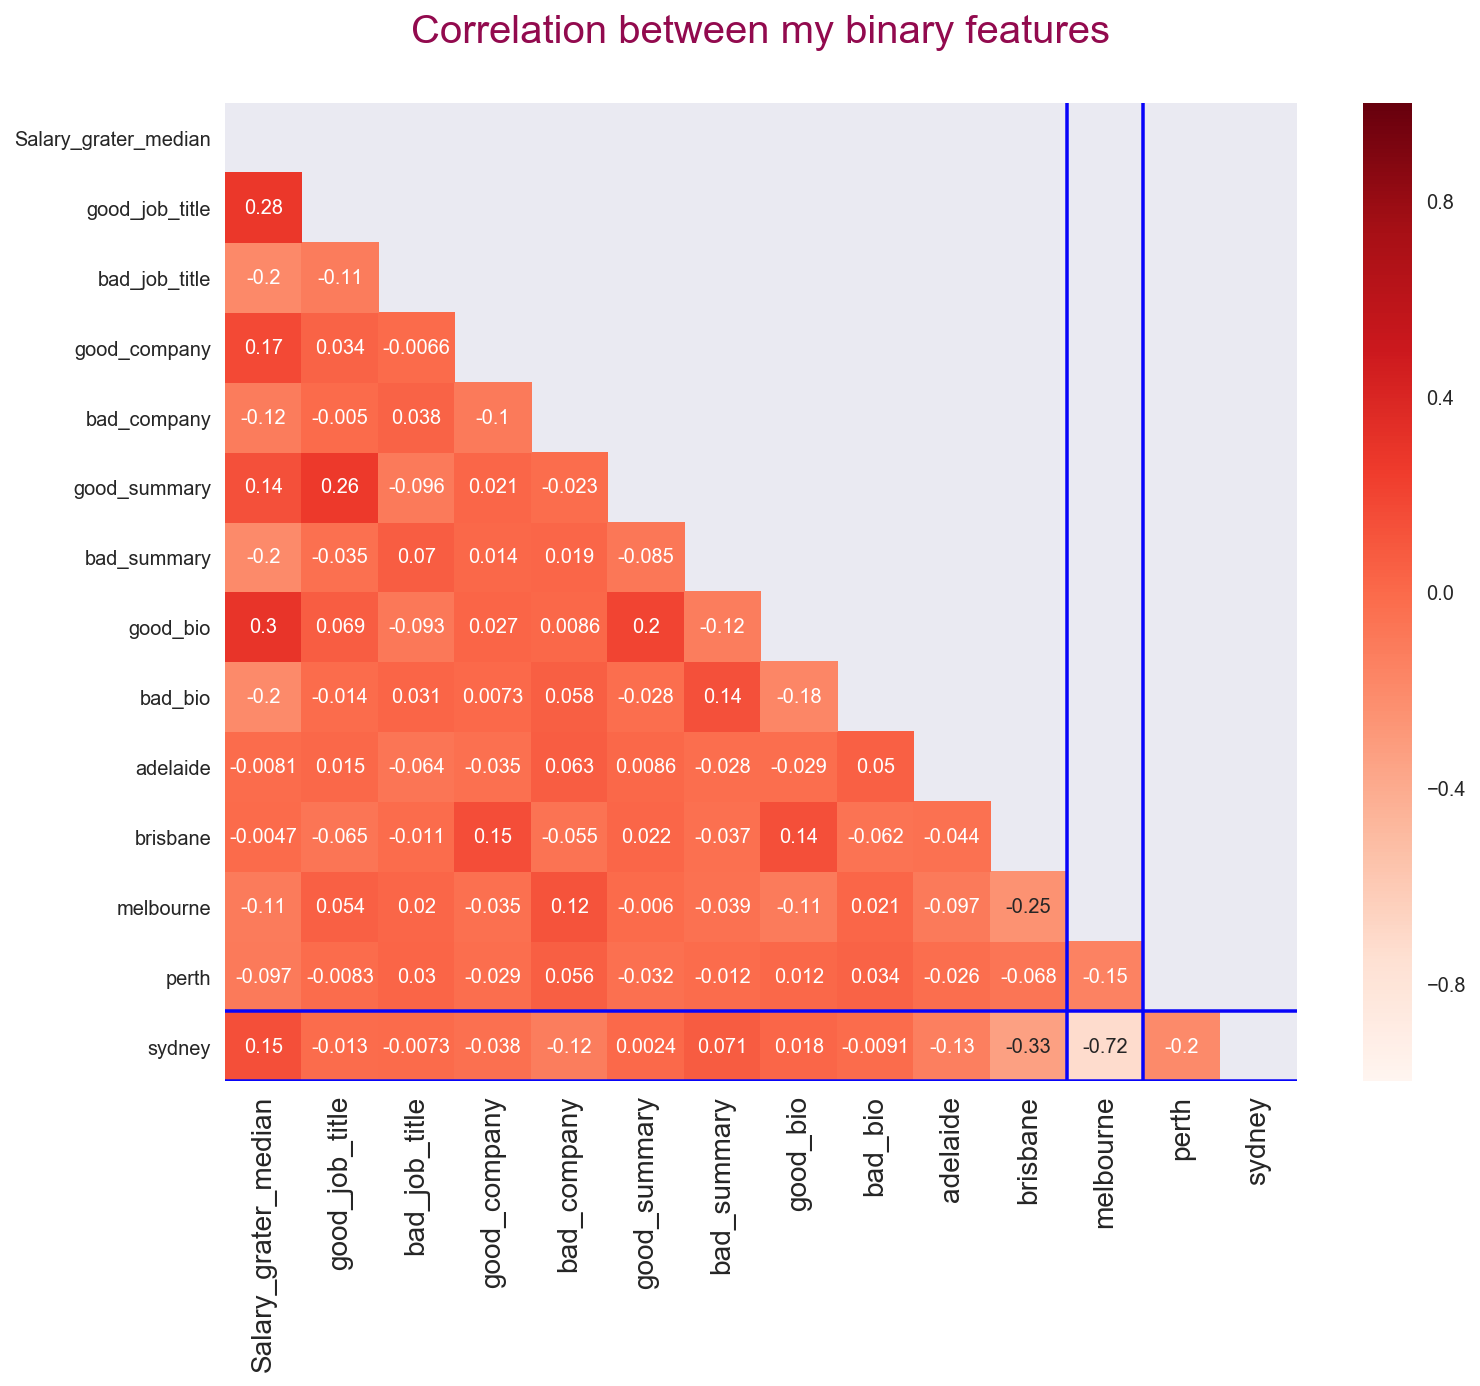

In [74]:
matrix = df_binary.corr() # get pearson r correlation 

fig, ax = plt.subplots(figsize=(12,9))
mask = np.zeros_like(matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.title('Correlation between my binary features', y=1.05, size = 20, color = '#920a4e')
ax = sns.heatmap(matrix, mask=mask, ax=ax, cmap='Reds', annot=True)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.hlines([0, 1], *ax.get_xlim(), colors='#0804f9')
ax.vlines([11, 12], *ax.get_xlim(), colors='#0804f9')

plt.show()

# <span style="color:#735c12">Modeling

<span style="color:red">
--- comment ---

<span style="color:#1d5dec">In this part I will use LinniarRegression model as I got binary data, and LR should give me good result if my features was colected in right way. 

In [75]:
# Get my target variable in 1D format.
# -----------------------------------------------------
target = df_binary.iloc[::,0]

In [77]:
# Get my predictors.
# -----------------------------------------------------
features = df_binary.iloc[::,1:]

In [79]:
print('df_binary shape: ',df_binary.shape)
print('target shape: ',target.shape)
print('features shape: ',features.shape)

df_binary shape:  (825, 14)
target shape:  (825,)
features shape:  (825, 13)


In [80]:
# Using train test split, I split my data into train and test parts.
# -----------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, stratify=target, random_state=34)

In [84]:
# Just check my train and test splited data shapes. 
# -----------------------------------------------------
print('X_train shape: ',X_train.shape)
print('X_test shape: ',X_test.shape)
print('-----------------')
print('y_train shape: ',y_train.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (618, 13)
X_test shape:  (207, 13)
-----------------
y_train shape:  (618,)
y_test shape:  (207,)


# <span style="color:#735c12">LogisticRegression

<span style="color:red">
--- comment ---

<span style="color:#1d5dec">First check my baseline. Then fit my LR model, with crossvalidation. I got score 0.73 which is very good compare to my baseline 0.54. I tested my data on test data set and got result 0.76 which is good. I will try then find better parameters for LR using GridSearch. 

In [88]:
# Baseline 
bl = 1 - target.mean()
print('Baseline: ', bl)

Baseline:  0.5406060606060605


In [85]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [86]:
print("Score:", lr.score(X_train, y_train))   
scores = cross_val_score(lr, X_train, y_train, cv = 6)
print("Cross-validated scores:", scores)

Score: 0.73786407767
Cross-validated scores: [ 0.76923077  0.71153846  0.69902913  0.6407767   0.71568627  0.74509804]


In [102]:
# Test my test data
# -----------------------------------------------------
y_probs = lr.predict(X_test)   
print("Score: ", lr.score(X_test, y_test))

Score:  0.763285024155


# <span style="color:#735c12">GridSerach for better parameters for LR

In [95]:
# Check what parameters I can use for LR.
# -----------------------------------------------------
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [101]:
lr_params = {
    'penalty':['l1','l2'],
    'C':np.logspace(-4, 2, 40),
    'solver':['liblinear']
}

lr_gs = GridSearchCV(LogisticRegression(), lr_params, cv=3, verbose=1)
lr_gs.fit(X_train, y_train)

best_lr = lr_gs.best_estimator_
print(lr_gs.best_params_)
print(lr_gs.best_score_)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
{'C': 0.49238826317067413, 'penalty': 'l2', 'solver': 'liblinear'}
0.731391585761


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    0.9s finished


<span style="color:red">
--- comment ---

<span style="color:#1d5dec">Using GridSearch I didn't find better parameters, so I will stick with what I have got. 

# <span style="color:#735c12">Create Confusion Matrix and classification report.

<span style="color:red">
--- comment ---

<span style="color:#1d5dec"> From the confusion matrix I can see that we have True positive predicted 69 and False positive 26, also 89 True Negative and 23 False negative. Overall acuracy is not too bad 0.76. 

In [103]:
# Printing confusion matrix 
# -----------------------------------------------------
print(confusion_matrix(y_test, y_probs,))

# Printing classification report
# -----------------------------------------------------
target_names = ['Below_median', 'Above_median']
print(classification_report(y_test, y_probs, target_names = target_names))

[[89 23]
 [26 69]]
              precision    recall  f1-score   support

Below_median       0.77      0.79      0.78       112
Above_median       0.75      0.73      0.74        95

 avg / total       0.76      0.76      0.76       207



# <span style="color:#820747">Predicting our salary with NaN values.

In [114]:
# Load data with all data including nan salary. 
# -----------------------------------------------------
null_salary = pd.read_csv('3_FOR_NLP.csv')

In [115]:
# Separate all nulls from our data
# -----------------------------------------------------
null_salary = null_salary[null_salary.salary.isnull()]

In [116]:
# Choose only data I need
# -----------------------------------------------------
predict_data = null_salary.iloc[::,0:7]

In [117]:
predict_data.head(2)

,location,title,company,salary,Salary_type,summary,job_bio
868,sydney,junior data analyst scientist,international institute of data analytics,NaN,NaN,in data science and big data analytics the id...,the international institute of data analytic...
869,sydney,senior data scientist,amazon com,NaN,NaN,a senior data scientist will our data scient...,excited by using massive amounts of data to de...


<span style="color:red">
--- comment ---

<span style="color:#1d5dec"> To predict my NaNs values I have to create dammy variables for this part of Data, I already got word from NLP, so I dont need to repeat it. Only make dummy.

In [118]:
# Title
# -----------------------------------------------------
predict_data["good_job_title"] = 0
predict_data.ix[(predict_data["title"].str.contains("senior business") | 
            predict_data["title"].str.contains("senior business analyst") | 
            predict_data["title"].str.contains("senior") |
            predict_data["title"].str.contains("lead") |
            predict_data["title"].str.contains("contract"), "good_job_title")] = 1

predict_data["bad_job_title"] = 0
predict_data.ix[(predict_data["title"].str.contains("digital") | 
            predict_data["title"].str.contains("commercial") | 
            predict_data["title"].str.contains("research") |
            predict_data["title"].str.contains("data analyst") |
            predict_data["title"].str.contains("management"), "bad_job_title")] = 1

In [120]:
# Company
# -----------------------------------------------------
predict_data["good_company"] = 0
predict_data.ix[(predict_data["company"].str.contains("hudson") |
                   predict_data["company"].str.contains("carter") |
                   predict_data["company"].str.contains("sharp carter"), "good_company")] = 1

predict_data["bad_company"] = 0
predict_data.ix[(predict_data["company"].str.contains("university") |
                   predict_data["company"].str.contains("page") |
                   predict_data["company"].str.contains("michael page"), "bad_company")] = 1

In [121]:
# Summary
# -----------------------------------------------------
predict_data["good_summary"] = 0
predict_data.ix[(predict_data["summary"].str.contains("senior business") |
                   predict_data["summary"].str.contains("business analysts") |
                   predict_data["summary"].str.contains("processes") |
                   predict_data["summary"].str.contains("develop") |
                   predict_data["summary"].str.contains("senior"), "good_summary")] = 1

predict_data["bad_summary"] = 0
predict_data.ix[(predict_data["summary"].str.contains("sales") |
                   predict_data["summary"].str.contains("commercial") |
                   predict_data["summary"].str.contains("analyst role") |
                   predict_data["summary"].str.contains("growth") |
                   predict_data["summary"].str.contains("reports"), "bad_summary")] = 1

In [122]:
# job_bio
# -----------------------------------------------------
predict_data["good_bio"] = 0
predict_data.ix[(predict_data["job_bio"].str.contains("extension") |
                   predict_data["job_bio"].str.contains("reporting analyst") |
                   predict_data["job_bio"].str.contains("business analysis") |
                   predict_data["job_bio"].str.contains("business process") |
                   predict_data["job_bio"].str.contains("architect"), "good_bio")] = 1

predict_data["bad_bio"] = 0
predict_data.ix[(predict_data["job_bio"].str.contains("institute") |
                   predict_data["job_bio"].str.contains("strong analytical") |
                   predict_data["job_bio"].str.contains("administrator") |
                   predict_data["job_bio"].str.contains("degree qualified") |
                   predict_data["job_bio"].str.contains("account"), "bad_bio")] = 1

In [124]:
# Cities
# -----------------------------------------------------
cities = pd.get_dummies(predict_data.location)
predict_data = pd.concat([predict_data, cities], axis=1)

In [126]:
# Drop unneeded columns and keep only binaries.
# -----------------------------------------------------
predict_data = predict_data.drop(['location', 'title', 'company', 'salary', 'Salary_type', 'summary', 'job_bio'], axis=1)

In [127]:
predict_data.head(2)

,good_job_title,bad_job_title,good_company,bad_company,good_summary,bad_summary,good_bio,bad_bio,adelaide,brisbane,melbourne,perth,sydney
868,0,1,0,0,0,0,0,1,0,0,0,0,1
869,1,0,0,0,1,0,0,0,0,0,0,0,1


In [128]:
predict_data.shape

(3570, 13)

<span style="color:red">
--- comment ---

<span style="color:#1d5dec"> Now I can start doing prediction for my NaN values, all data ready for this. After prediction there is one more column in my null_salary DataFrame, where I have got predicted salary.

In [129]:
# Generating median salary predictions for unsalaried job postings
# -----------------------------------------------------
predict_salary = lr.predict(predict_data)   
null_salary["Salary_grater_median"] = predict_salary

In [131]:
null_salary.head(3)

,location,title,company,salary,Salary_type,summary,job_bio,level,Salary_grater_median
868,sydney,junior data analyst scientist,international institute of data analytics,NaN,NaN,in data science and big data analytics the id...,the international institute of data analytic...,junior,0.0
869,sydney,senior data scientist,amazon com,NaN,NaN,a senior data scientist will our data scient...,excited by using massive amounts of data to de...,senior,1.0
870,sydney,data scientist,buildingiq,NaN,NaN,we are looking for a data scientist to be a pa...,job description location – sydney australia...,middle,1.0


In [132]:
# Check how many 0 and 1 I got. Seems almost the same. 
# -----------------------------------------------------
null_salary.Salary_grater_median.value_counts()

0.0    1831
1.0    1739
Name: Salary_grater_median, dtype: int64

In [133]:
# Almost 49% in data above median salary, and 51% below median salary. 
# -----------------------------------------------------
null_salary.Salary_grater_median.mean()

0.48711484593837534

<span style="color:red">
--- comment ---

<span style="color:#1d5dec">I plot 2 graph. 1st with predicted salary and 2nd one with given salary. I can see on this two graphs they are have same shapes, just a bit different. Now I want to concatenate my predicted data with given. 

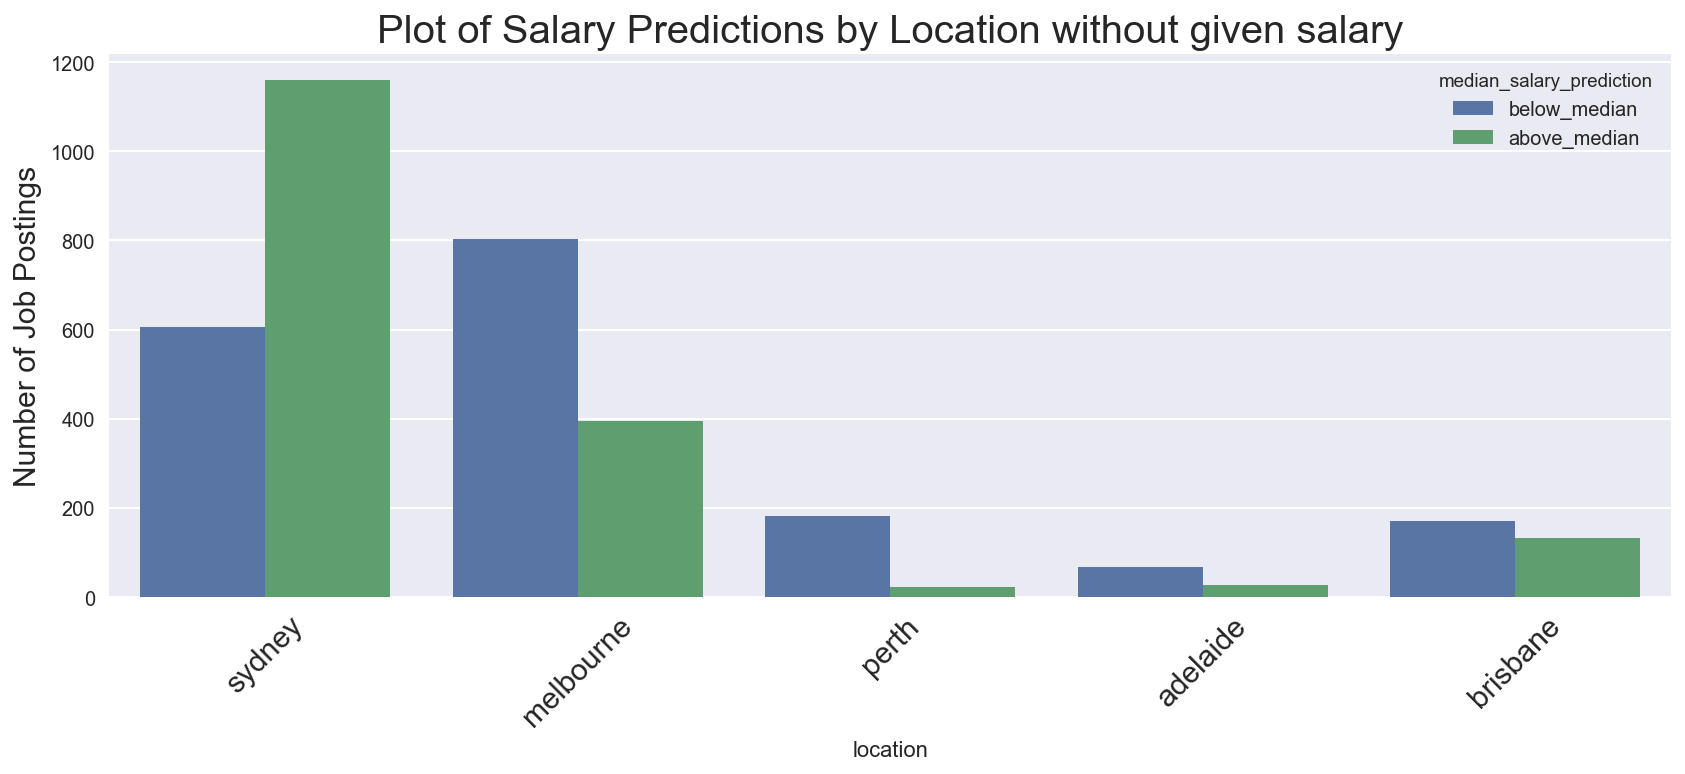

In [152]:
# Data which was without salary. Salary was predicted. 
# -----------------------------------------------------
fig, ax = plt.subplots(figsize=(14,5))
city_predictions = pd.DataFrame(null_salary[["location", "Salary_grater_median"]])
city_predictions['median_salary_prediction'] = city_predictions.Salary_grater_median.map({0:"below_median", 1:"above_median"})
sns.countplot(x = "location", hue = "median_salary_prediction", data = city_predictions)
plt.ylabel("Number of Job Postings",fontsize=15)
plt.xticks(rotation = 45,fontsize=15)
sns.plt.title('Plot of Salary Predictions by Location without given salary',fontsize=20)
plt.show()

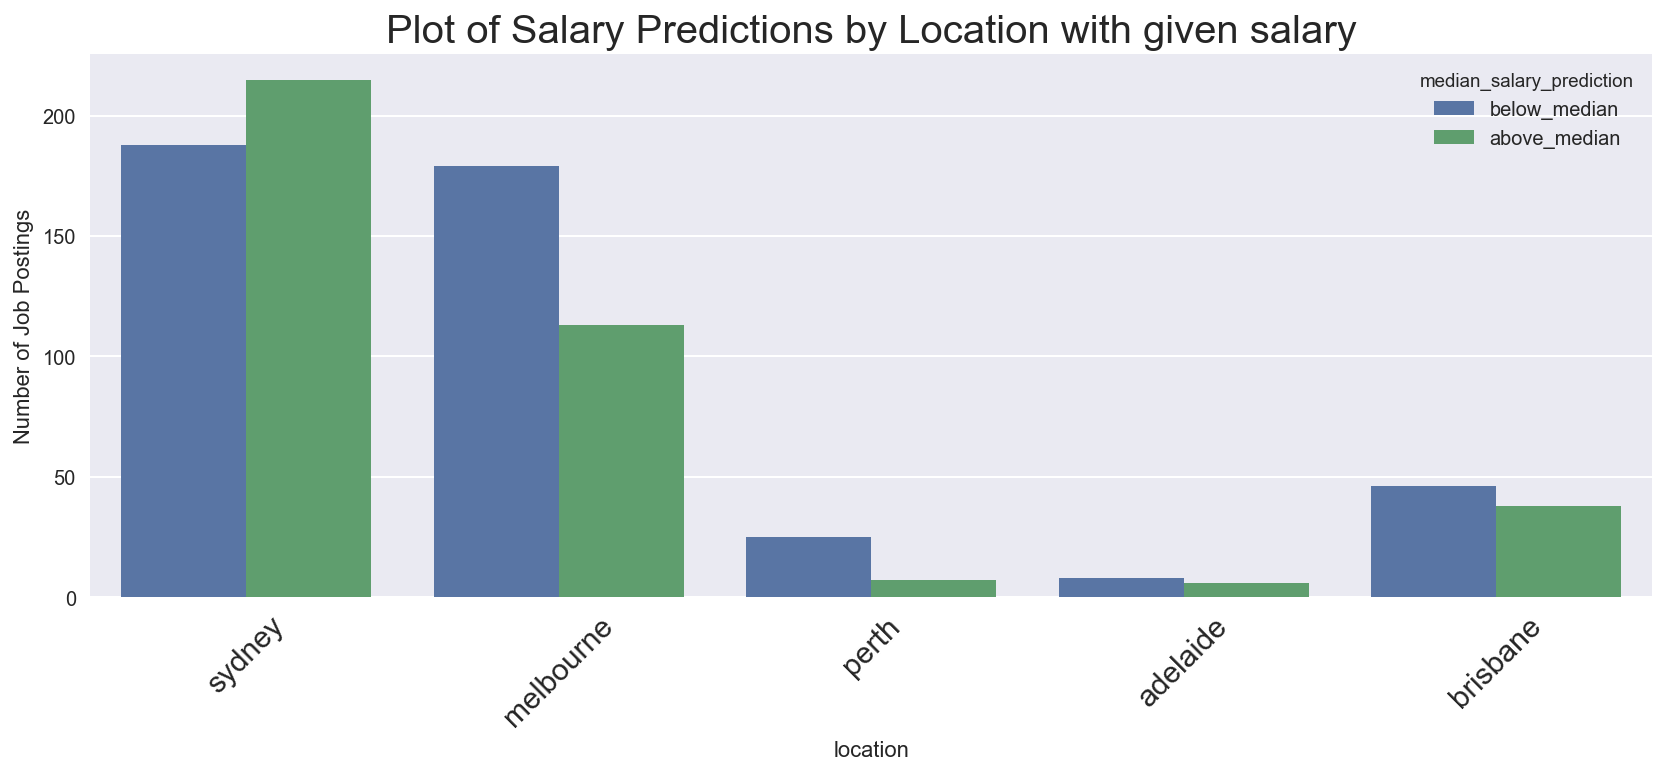

In [148]:
# Data which was with a given salary
# -----------------------------------------------------
fig, ax = plt.subplots(figsize=(14,5))
city_predictions1 = pd.DataFrame(df[["location", "Salary_grater_median"]])
city_predictions1['median_salary_prediction'] = city_predictions1.Salary_grater_median.map({0:"below_median", 1:"above_median"})
sns.countplot(x = "location", hue = "median_salary_prediction", data = city_predictions1)
plt.ylabel("Number of Job Postings")
plt.xticks(rotation = 45,fontsize=15)
sns.plt.title('Plot of Salary Predictions by Location with given salary', fontsize=20)
plt.show()

In [153]:
df_with_sal_NoNulls = df[df['salary'].notnull()]

In [156]:
# Concatenate our 2 DataFrames 
# -----------------------------------------------------
df_all_salary = pd.concat([df_with_sal_NoNulls, null_salary], axis=0)

In [158]:
# Check for shape. I have got 4395 which is seems right. 
# -----------------------------------------------------
df_all_salary.shape

(4395, 9)

In [159]:
df_all_salary.head(2)

,location,title,company,salary,Salary_type,summary,job_bio,level,Salary_grater_median
0,sydney,data science research engineer,macquarie university,106382.0,year,we are seeking a data science research enginee...,macquarie is the university of pioneering mind...,middle,0.0
1,sydney,senior software engineer machine learning,rokt,137500.0,year,a strong statistical background and or experie...,exceptional opportunity to join one of the fas...,senior,1.0


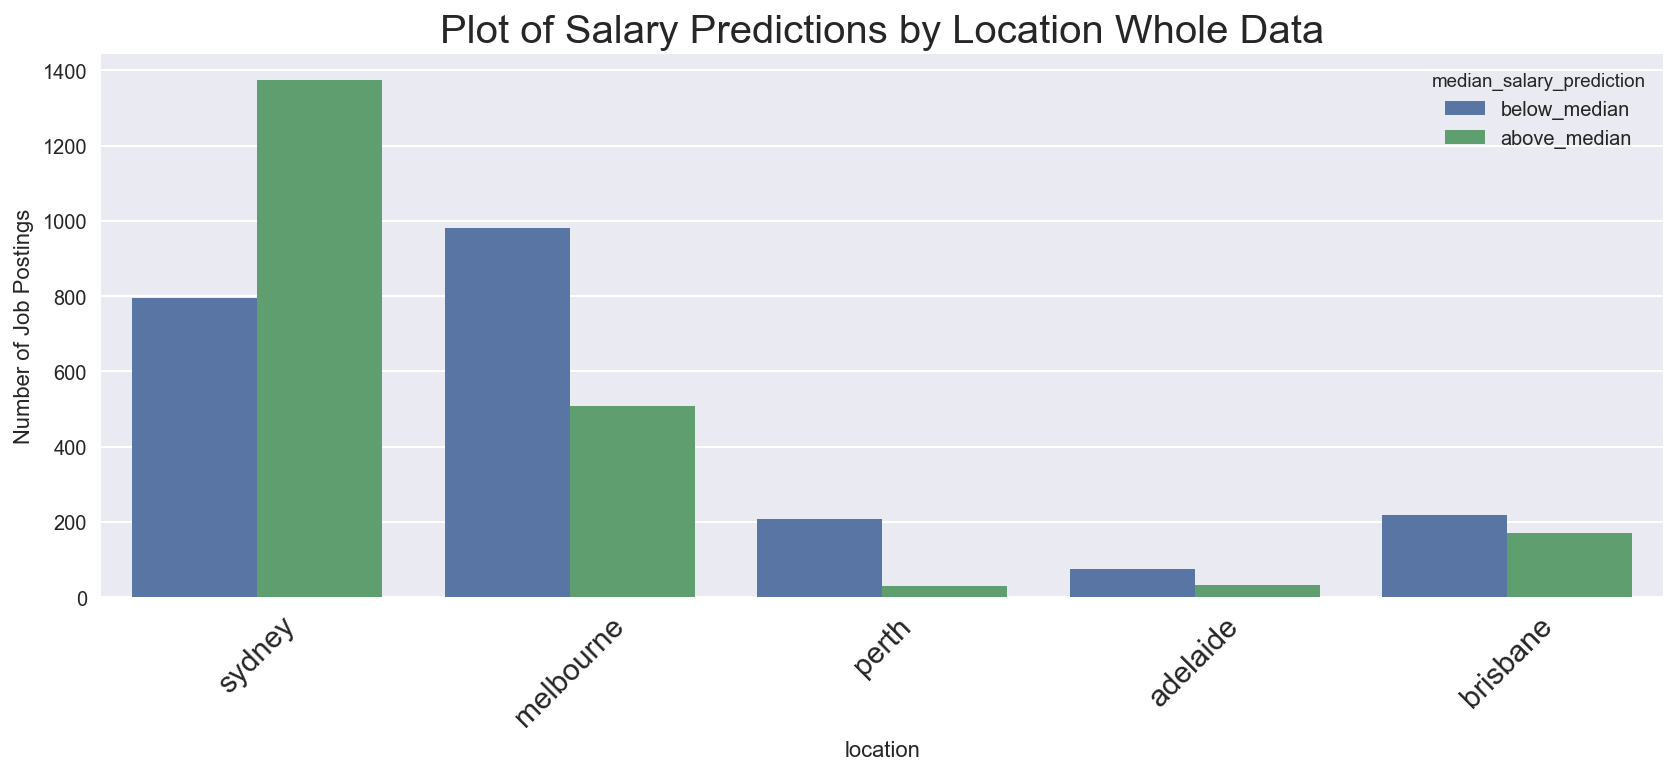

In [160]:
# Concatenated data. We can now compare to 2 graphs above. 
# -----------------------------------------------------
fig, ax = plt.subplots(figsize=(14,5))
city_predictions1 = pd.DataFrame(df_all_salary[["location", "Salary_grater_median"]])
city_predictions1['median_salary_prediction'] = city_predictions1.Salary_grater_median.map({0:"below_median", 1:"above_median"})
sns.countplot(x = "location", hue = "median_salary_prediction", data = city_predictions1)
plt.ylabel("Number of Job Postings")
plt.xticks(rotation = 45,fontsize=15)
sns.plt.title('Plot of Salary Predictions by Location Whole Data',  fontsize=20)
plt.show()

In [161]:
# Save new clean and predicted data.
# -----------------------------------------------------
df_all_salary.to_csv('ALL_SALARY_PREDICTED.csv')